In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool, cpu_count
import gc; gc.enable()
import xgboost as xgb
import pandas as pd
pd.set_option('max_columns',1000)
import numpy as np
from sklearn import *
import sklearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.preprocessing import Imputer
from mylibs.WSDN_FUNC import *
%cd e:\kaggle\wsdm
%matplotlib inline

e:\kaggle\wsdm


D:\Miniconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Miniconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
D:\Miniconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [90]:
def change_datatype(df):
    int_cols = list(df.select_dtypes(include=['int']).columns)
    for col in int_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

def change_datatype_float(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        df[col] = df[col].astype(np.float32)

def plot_precision_recall_vs_threshold(train_y, scores):
    from sklearn.metrics import precision_recall_curve
    precisions, recalls, thresholds = precision_recall_curve(train_y, scores)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recalls")
    plt.xlabel("Threshold")
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    plt.xticks(np.arange(0, 1, 0.03))
    plt.grid(True, linestyle='-.')
    plt.show()
    
def plot_roc_curve(train_y, scores):
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(train_y, scores)
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 0], [1, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [2]:
# prepare base data
print("reading training and submission data...")
train = pd.read_csv("train.csv/train.csv")
test = pd.read_csv("sample_submission.csv/sample_submission.csv")

reading training and submission data...


In [3]:
print("processing transaction data...")
transactions = pd.read_csv('transactions.csv/transactions.csv')
date_cols = ['transaction_date', 'membership_expire_date']
for col in date_cols:
    transactions[col] = pd.to_datetime(transactions[col], format='%Y%m%d')
    
print("----processing transaction counts data...")
transaction_counts = transactions['msno'].value_counts().reset_index()
transaction_counts.columns = ['msno','trans_count']
train = pd.merge(train, transaction_counts, how='left', on='msno')
test = pd.merge(test, transaction_counts, how='left', on='msno')
transaction_counts=[]
gc.collect()

print("----processing transaction last record data...")
transaction_last_date = transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)
transaction_last_date = transaction_last_date.drop_duplicates(subset=['msno'], keep='first')
transaction_last_date["discount"] = transaction_last_date['plan_list_price'] - transaction_last_date['actual_amount_paid']
transaction_last_date['is_discount'] = transaction_last_date.discount.apply(lambda x: 1 if x > 0 else 0)
transaction_last_date['amt_per_day'] = transaction_last_date['actual_amount_paid'] / transaction_last_date['payment_plan_days']
transaction_last_date['membership_duration'] = transaction_last_date.membership_expire_date - transaction_last_date.transaction_date
transaction_last_date['membership_duration'] = transaction_last_date['membership_duration'] / np.timedelta64(1, 'D')
transaction_last_date['membership_duration'] = transaction_last_date['membership_duration'].astype(int)
transaction_last_date = transaction_last_date.drop(list(transaction_last_date.select_dtypes(include=['datetime64[ns]']).columns), 1)
train = pd.merge(train, transaction_last_date, how='left', on='msno')
test = pd.merge(test, transaction_last_date, how='left', on='msno')
print('----retain transaction_last_date for members.')

print("----processing transaction last 2 months counts data...")
transaction_last2 = transactions.sort_values(by=['transaction_date'], ascending=[True]).reset_index(drop=True)
transaction_last2 = transaction_last2.set_index("transaction_date").truncate(before = '2017-02-01').reset_index()
transaction_last2 = pd.DataFrame(transaction_last2['msno'].value_counts().reset_index())
transaction_last2.columns = ['msno','trans_count2']
train = pd.merge(train, transaction_last2, how='left', on='msno')
test = pd.merge(test, transaction_last2, how='left', on='msno')
transaction_last2 = []
transactions = []
gc.collect()
print('transaction merged.')

processing transaction data...
----processing transaction counts data...
----processing transaction last record data...
----retain transaction_last_date for members.
----processing transaction last 2 months counts data...
transaction merged.


In [4]:
print("processing member data...")
members = pd.read_csv('members.csv/members.csv')
df_comb = pd.merge(transaction_last_date, members, on='msno', how='inner')
df_comb['autorenew_&_not_cancel'] = ((df_comb.is_auto_renew == 1) == (df_comb.is_cancel == 0)).astype(np.int8)
df_comb['notAutorenew_&_cancel'] = ((df_comb.is_auto_renew == 0) == (df_comb.is_cancel == 1)).astype(np.int8)
drop_cols = list(members.select_dtypes(include=['datetime64[ns]']).columns) + list(transaction_last_date.columns)
drop_cols.remove('msno')
df_comb = df_comb.drop(drop_cols, 1)
train = pd.merge(train, df_comb, how='left', on='msno')
test = pd.merge(test, df_comb, how='left', on='msno')
print("----data clean...")
gender = {'male':1, 'female':2}
train['gender'] = train['gender'].map(gender)
test['gender'] = test['gender'].map(gender)
train_bd_clipped = train["bd"].clip(18, 60)
test_bd_clipped = test["bd"].clip(18, 60)
train_bd_mean = train_bd_clipped.mean()
test_bd_mean = test_bd_clipped.mean()
train["bd"] = train["bd"].apply(lambda x: train_bd_mean if x <18 or x >60 else x )
test["bd"] = test["bd"].apply(lambda x: test_bd_mean if x <18 or x >60 else x )
train_bd_clipped = []
test_bd_clipped = []
transaction_last_date = []
members = []
df_comb = []
gc.collect()
print('members merged.')

processing member data...
----data clean...
members merged.


In [5]:
print("processing logs data...")
df_iter = pd.read_csv('user_logs.csv/user_logs.csv', low_memory=False, iterator=True, chunksize=10000000)
last_user_logs = []
i = 0 
for df in df_iter:
    if len(df)>0:
        print(df.shape)
        p = Pool(cpu_count())
        df = p.map(transform_df, np.array_split(df, cpu_count()))   
        df = pd.concat(df, axis=0, ignore_index=True).reset_index(drop=True)
        df = transform_df2(df)
        p.close(); p.join()
        last_user_logs.append(df)
        print('...', df.shape)
        df = []
        gc.collect()
    i+=1

last_user_logs = pd.concat(last_user_logs, axis=0, ignore_index=True).reset_index(drop=True)
last_user_logs = transform_df2(last_user_logs)

train = pd.merge(train, last_user_logs, how='left', on='msno')
test = pd.merge(test, last_user_logs, how='left', on='msno')
last_user_logs=[]
gc.collect()
print('logs merged.')

processing logs data...
(10000000, 9)
... (1617125, 9)
(10000000, 9)
... (1435325, 9)
(10000000, 9)
... (1587111, 9)
(10000000, 9)
... (1617485, 9)
(10000000, 9)
... (1503164, 9)
(10000000, 9)
... (1421066, 9)
(10000000, 9)
... (1549800, 9)
(10000000, 9)
... (1617062, 9)
(10000000, 9)
... (1382457, 9)
(10000000, 9)
... (1458460, 9)
(10000000, 9)
... (1616573, 9)
(10000000, 9)
... (1616680, 9)
(10000000, 9)
... (1339407, 9)
(10000000, 9)
... (1460577, 9)
(10000000, 9)
... (1616781, 9)
(10000000, 9)
... (1546283, 9)
(10000000, 9)
... (1460571, 9)
(10000000, 9)
... (1567824, 9)
(10000000, 9)
... (1616909, 9)
(10000000, 9)
... (1473617, 9)
(10000000, 9)
... (1455686, 9)
(10000000, 9)
... (1616748, 9)
(10000000, 9)
... (1536417, 9)
(10000000, 9)
... (1420089, 9)
(10000000, 9)
... (1533579, 9)
(10000000, 9)
... (1617245, 9)
(10000000, 9)
... (1527783, 9)
(10000000, 9)
... (1419061, 9)
(10000000, 9)
... (1586640, 9)
(10000000, 9)
... (1616797, 9)
(10000000, 9)
... (1488283, 9)
(10000000, 9)
.

In [6]:
# extra features
print("processing extra features...")
extra_features = pd.read_csv("extra_features.csv")
train = pd.merge(train, extra_features, how='left', on='msno')
test = pd.merge(test, extra_features, how='left', on='msno')
extra_features3 = pd.read_csv("extra_features3.csv")
train = pd.merge(train, extra_features3, how='left', on='msno')
test = pd.merge(test, extra_features3, how='left', on='msno')
extra_features = []
extra_features3 = []
gc.collect()
print("extra features merged.")

processing extra features...
extra features merged.


In [46]:
train.to_csv('train_features.csv', index=False)
test.to_csv('test_features.csv', index=False)

In [2]:
# training preparation
train = pd.read_csv("train_features.csv")
test = pd.read_csv("test_features.csv")
# missing values
data_pack = [train, test]
for i, data in enumerate(data_pack):
    data = data.replace([np.inf, -np.inf], np.nan)
    mean_cols = ['trans_count', 'payment_plan_days', 'plan_list_price', 'actual_amount_paid', 'discount', 'amt_per_day', 'membership_duration', 'trans_count2', 'bd', 'log_count']
    mode_cols = ['payment_method_id', 'is_auto_renew', 'is_cancel', 'is_discount', 'city', 'gender', 'registered_via', 'registration_init_time', 'autorenew_&_not_cancel', 'notAutorenew_&_cancel', 'date']
    other_cols = [col for col in (data.columns) if col not in mean_cols if col not in mode_cols]
    data[mean_cols] = data[mean_cols].fillna(data[mean_cols].mean())
    data[mode_cols] = data[mode_cols].fillna(data[mode_cols].mode())
    data[other_cols]= data[other_cols].fillna(0)
    data_pack[i] = data
train, test = data_pack
gc.collect()

35

In [21]:
change_datatype(train);change_datatype(test)
change_datatype_float(train);change_datatype_float(test)

In [16]:
# select training features
cols = [col for col in train.columns if col not in ['is_churn','msno'] if not col.endswith("mean")]
cols

['trans_count',
 'payment_method_id',
 'payment_plan_days',
 'plan_list_price',
 'actual_amount_paid',
 'is_auto_renew',
 'is_cancel',
 'discount',
 'is_discount',
 'amt_per_day',
 'membership_duration',
 'trans_count2',
 'city',
 'bd',
 'gender',
 'registered_via',
 'registration_init_time',
 'autorenew_&_not_cancel',
 'notAutorenew_&_cancel',
 'date',
 'num_25',
 'num_50',
 'num_75',
 'num_985',
 'num_100',
 'num_unq',
 'total_secs',
 'num_25_sum',
 'num_50_sum',
 'num_75_sum',
 'num_985_sum',
 'num_100_sum',
 'num_unq_sum',
 'total_secs_sum',
 'log_count']

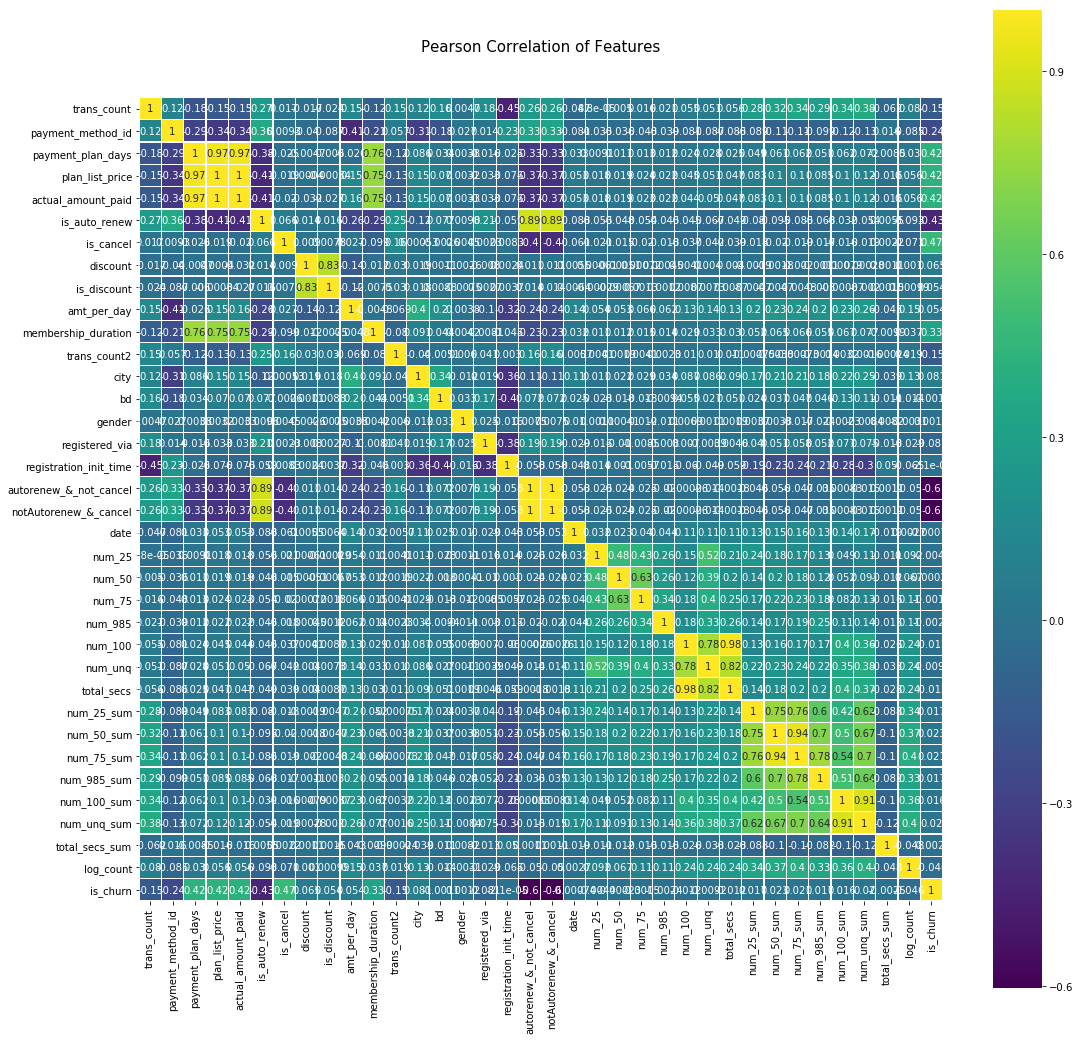

In [4]:
colormap = plt.cm.viridis
plt.figure(figsize=(18,18))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train[cols + ["is_churn"]].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [92]:
if 'final_train_data' in locals():
    del final_train_data
if 'final_test_data' in locals():
    del final_test_data
if 'final_xgb_model' in locals():
    del final_xgb_model
if 'x1' in locals():
    del x1;del x2;del y1;del y2
gc.collect()  
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)
new_feature_cols = [] 
xgb_params = {
        'eta': 0.02, #use 0.002
        'max_depth': 7,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'seed': i,
        'silent': True,       
        'tree_method': 'gpu_hist',
    }
for i, (train_index, test_index) in enumerate(kf):
    print("training round %d" % i)
    train_data = train.iloc[train_index]
    training_test_data = train.iloc[test_index]
    eval_list = [(xgb.DMatrix(train_data[cols], train_data["is_churn"]), 'train'), (xgb.DMatrix(training_test_data[cols], training_test_data["is_churn"]), 'validation')]
    model = xgb.train(xgb_params, xgb.DMatrix(train_data[cols], train_data["is_churn"]), 150, evals=eval_list, maximize=False, verbose_eval=50, early_stopping_rounds=50)
    training_prediction = model.predict(xgb.DMatrix(training_test_data[cols]), ntree_limit=model.best_ntree_limit)
    test_prediction = model.predict(xgb.DMatrix(test[cols]), ntree_limit=model.best_ntree_limit)
    new_feature = 'xgb_feature_%d' % i
    training_prediction = pd.DataFrame(training_prediction.clip(0.0000001, 0.999999), columns=[new_feature])
    test_prediction = pd.DataFrame(test_prediction.clip(0.0000001, 0.999999), columns=[new_feature])
    new_feature_cols += [new_feature]
    if i == 0:
        xgb_training_predctions = training_prediction
        xgb_test_predictions = test_prediction
    else:
        xgb_training_predctions = pd.concat([xgb_training_predctions, training_prediction], axis=1)
        xgb_test_predictions = pd.concat([xgb_test_predictions, test_prediction], axis=1)
    print(new_feature_cols)
    del train_data
    del training_test_data
    del training_prediction
    del test_prediction
    del model
    gc.collect()
print("stacking training.")
final_train_data = pd.concat([train, xgb_training_predctions], axis=1)
final_test_data = pd.concat([test, xgb_test_predictions], axis=1)
new_feature_cols = cols + new_feature_cols
x1, x2, y1, y2 = model_selection.train_test_split(final_train_data[new_feature_cols], final_train_data['is_churn'], test_size=0.3, random_state=SEED)
eval_list = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
final_xgb_model = xgb.train(xgb_params, xgb.DMatrix(x1, y1), 150, evals=eval_list, maximize=False, verbose_eval=50, early_stopping_rounds=50)
final_preds = final_xgb_model.predict(xgb.DMatrix(final_test_data[new_feature_cols]), ntree_limit=final_xgb_model.best_ntree_limit)
test['is_churn'] = final_preds.clip(0.0000001, 0.999999)
test[['msno','is_churn']].to_csv('submission.csv.gz', index=False, compression='gzip')
if 'xgb_training_predctions' in locals():
    del xgb_training_predctions
if 'xgb_test_predictions' in locals():
    del xgb_test_predictions
gc.collect()

training round 0
[0]	train-logloss:0.674245	validation-logloss:0.676455
Multiple eval metrics have been passed: 'validation-logloss' will be used for early stopping.

Will train until validation-logloss hasn't improved in 50 rounds.
[50]	train-logloss:0.220954	validation-logloss:0.284644
[100]	train-logloss:0.098615	validation-logloss:0.186423
[149]	train-logloss:0.058467	validation-logloss:0.158003
['xgb_feature_0']
training round 1
[0]	train-logloss:0.674845	validation-logloss:0.674196
Multiple eval metrics have been passed: 'validation-logloss' will be used for early stopping.

Will train until validation-logloss hasn't improved in 50 rounds.
[50]	train-logloss:0.237104	validation-logloss:0.218808
[100]	train-logloss:0.120325	validation-logloss:0.095517
[149]	train-logloss:0.08216	validation-logloss:0.054659
['xgb_feature_0', 'xgb_feature_1']
training round 2
[0]	train-logloss:0.674847	validation-logloss:0.67419
Multiple eval metrics have been passed: 'validation-logloss' will be us

37

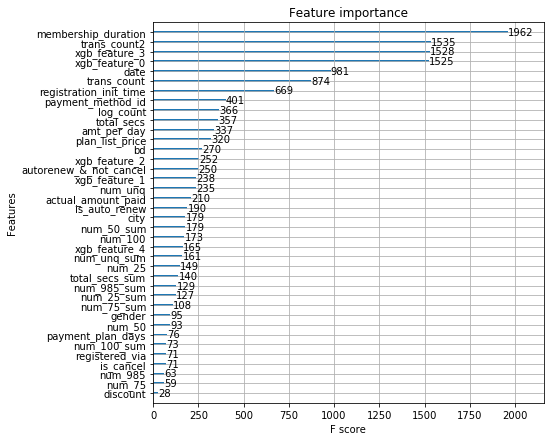

In [93]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)
xgb.plot_importance(booster=final_xgb_model)
plt.show()

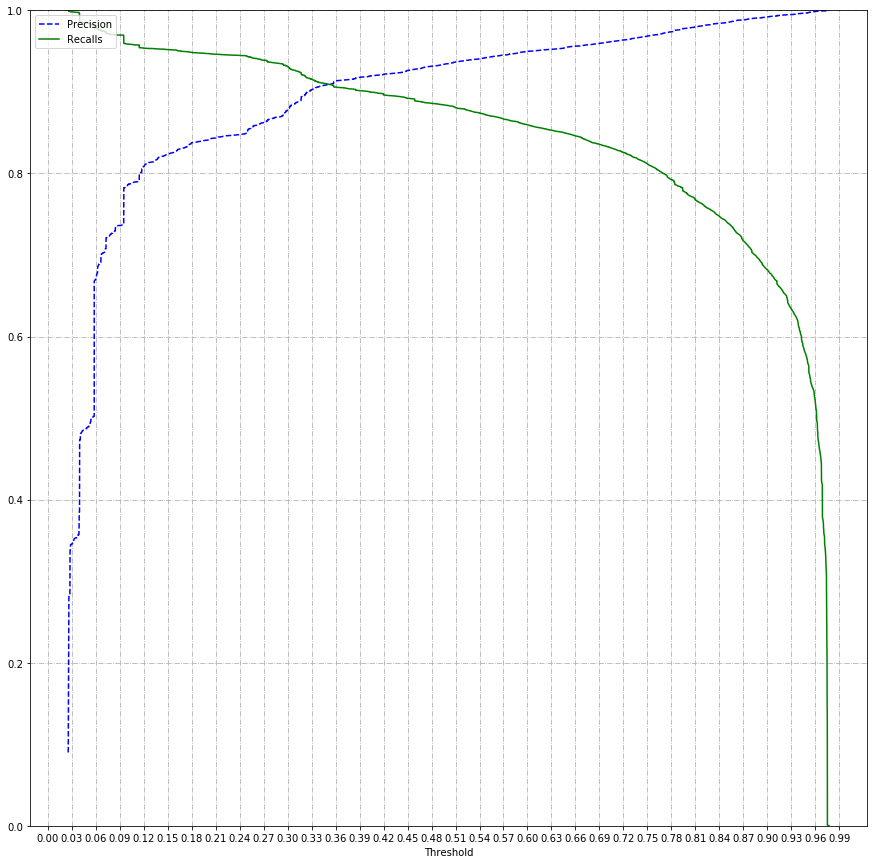

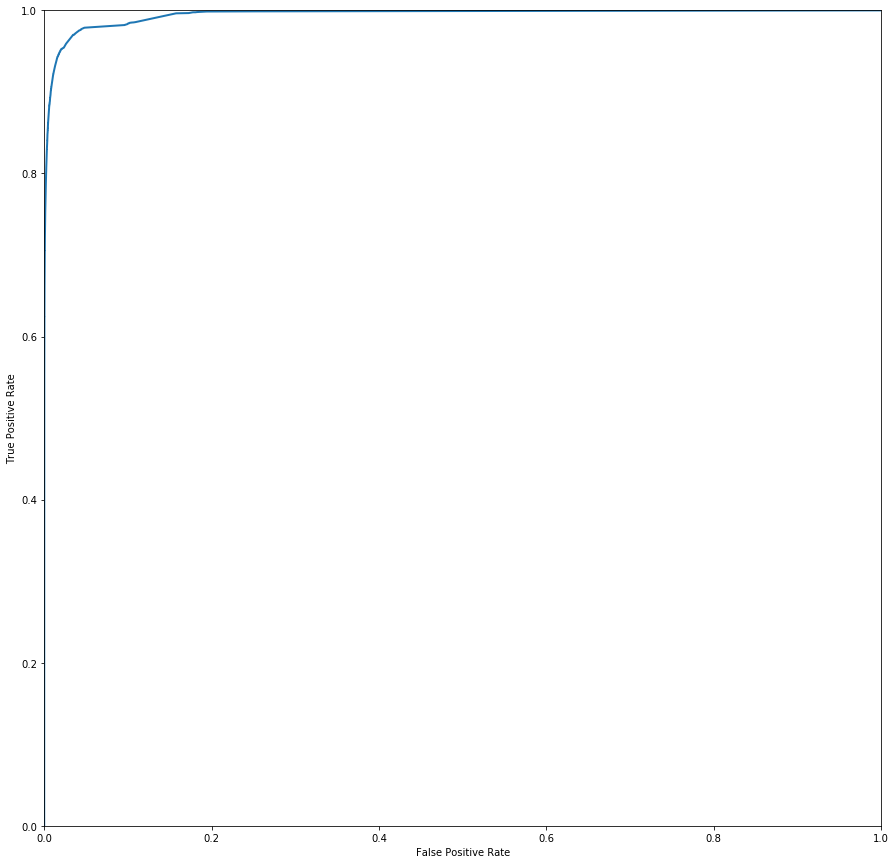

13044

In [91]:
train_preds = final_xgb_model.predict(xgb.DMatrix(x2), ntree_limit=final_xgb_model.best_ntree_limit)
train_preds = train_preds.clip(0.0000001, 0.999999)
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plot_precision_recall_vs_threshold(y2, train_preds)
plot_roc_curve(y2, train_preds)
gc.collect()